# General Overview
## Introductory Overview of PyMC
>Note: This text is partly based on the PeerJ CS publication on PyMC by John Salvatier, Thomas V. Wiecki, and Christopher Fonnesbeck.

### Abstract
確率プログラミングは、ユーザーが定義した確率モデルに対して自動的にベイズ推論を行うことができる。ハミルトニアンモンテカルロ(HMC)として知られるマルコフ連鎖モンテカルロ(MCMC)サンプリングのための勾配ベースのアルゴリズムは、ますます複雑なモデルの推論を可能にするが、しばしば計算が容易ではない勾配情報を必要とする。PyMCはPythonで書かれたオープンソースの確率プログラミングフレームワークであり、PyTensorを使用して自動微分により勾配を計算し、高速化のために計算バックエンドの1つに確率プログラムをオンザフライでコンパイルします。PyMCはドメイン固有の言語ではなく、Pythonのコードでモデルの仕様を記述できるため、学習、カスタマイズ、デバッグが容易です。本論文は、ベイズ統計にある程度慣れている人向けの、このソフトウェアパッケージのチュートリアルスタイルの紹介である。

### Introduction
確率プログラミング(PP)は、ベイズ統計モデルをコードで柔軟に指定することができます。PyMCは、直感的で読みやすく、しかも強力な構文を持つPPフレームワークであり、統計学者がモデルを記述するのに使う自然な構文に近い。ハミルトニアンモンテカルロ(Hamiltonian Monte Carlo; HMC; Duane, 1987)の自己調整型であるNo-U-Turn Sampler (NUTS; Hoffman, 2014)のような次世代のマルコフ連鎖モンテカルロ(MCMC)サンプリングアルゴリズムを備えています。このクラスのサンプラーは、高次元で複雑な事後分布でうまく機能し、適合アルゴリズムに関する専門的な知識がなくても、多くの複雑なモデルを適合させることができる。HMCとNUTSは、尤度からの勾配情報を利用して、従来のサンプリング法よりも、特に大きなモデルに対して、はるかに速い収束を実現します。NUTSはまた、ハミルトニアンモンテカルロの調整可能なパラメータを適応的に設定するためのいくつかの自己調整戦略を持っており、通常、アルゴリズムがどのように機能するかについての専門的な知識は必要ありません。


Pythonによる確率プログラミングは、マルチプラットフォーム互換性、表現力豊かでありながらすっきりと読みやすい構文、他の科学ライブラリとの容易な統合、C、C++、Fortran、Cythonによる拡張性など、多くの利点をもたらす。これらの特徴により、ベイズ分析で必要とされるカスタム統計分布、サンプラー、変換関数を比較的簡単に記述し、使用することができる。


PyMCのユーザー向け機能のほとんどは純粋なPythonで書かれているが、PyTensor（Theanoプロジェクトのフォーク）を活用して、透過的にモデルをCにトランスコードし、機械語コードにコンパイルすることで、パフォーマンスを向上させている。PyTensorは、テンソルと呼ばれる一般化されたベクトルデータ構造を使って式を定義することを可能にするライブラリで、一般的なNumPyの```ndarray```データ構造と緊密に統合されており、NumPyの配列がそうであるように、同様にブロードキャストや高度なインデックス付けを可能にします。また、PyTensorは自動的に尤度の計算グラフを最適化し、JaxやNumbaを含む一連の計算バックエンドにコンパイルすることができます。


ここでは、一般的なベイズ統計的推論や予測問題を解くためのPyMCの使い方を紹介します。まず、PyMCの使い方の基本を簡単な例で説明します：インストール、データ作成、モデル定義、モデルフィッティング、事後解析です。その後、2つのケーススタディを取り上げ、より洗練されたモデルの定義と適合の方法を紹介します。最後に、カスタム分布と任意の決定論的ノードという便利な機能について説明します。

### Installation
PyMCを実行するには、比較的新しいPythonインタプリタ、できればバージョン3.8以上が必要です。macOS、Linux、Windows用の完全なPythonのインストールは、ContinuumIOによる無料の```Anaconda Python Distribution```またはオープンソースのMiniforgeをダウンロードしてインストールすることで最も簡単に入手できます。


Pythonをインストールしたら、PyMCのドキュメントサイトにあるインストールガイドに従ってください。


PyMCは自由なApache License 2.0の下で配布されています。GitHubサイトでは、バグやその他の問題を報告したり、ドキュメントやコードをプロジェクトに貢献することができます。

### A Motivating Example: Linear Regression

モデルの定義、フィッティング、事後分析を紹介するために、まず、パラメータの正規分布事前分布を持つ単純なベイズ線形回帰モデルを考える。我々は，期待値を持つ正規分布オブザベーションとして $Y$を持つ正規分布オブザベーションとして予測することに興味がある.これは2つの予測変数$X_1$,$X_2$の1次関数である.:

$$
Y \sim \mathcal{N} (\mu, \sigma^2)\\
\mu = \alpha + \beta _1 X_1 + \beta _2 X_2
$$
 
ここで $\alpha$は切片で$\beta _i$は共変量,一方$\sigma$は観測誤差を表す．我々はベイズ・モデルを構築しているので、モデル中の未知変数に事前分布を割り当てなければならない。我々は、両方の回帰係数について、分散が100のゼロ平均正規事前分布を選びますが、これは真のパラメータ値に関する弱い情報に対応します。$\sigma$の事前分布として，半正規分布（ゼロで境界づけられた正規分布）を選ぶ．

$$
\alpha \sim \mathcal{N} (0, 10^2)\\
\beta _i \sim \mathcal{N} (0, 10^2)\\
\sigma \sim \bigl| \mathcal{N} (0, 1) \bigr|
$$

#### Generating data
NumPyの```random```モジュールだけを使って、このモデルからいくつかの人工的なデータをシミュレートし、PyMCを使って対応するパラメータの復元を試みることができます。意図的にPyMCのモデル構造に近いデータを生成しています。

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
# True parameter values
alpha = 1
beta = [1, 2.5]
sigma = 1

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size = size) * sigma

シミュレートされたデータは以下のようになる。プロットライブラリmatplotlibの```pylab```モジュールを使用しています。

Text(0.5, 0, 'X2')

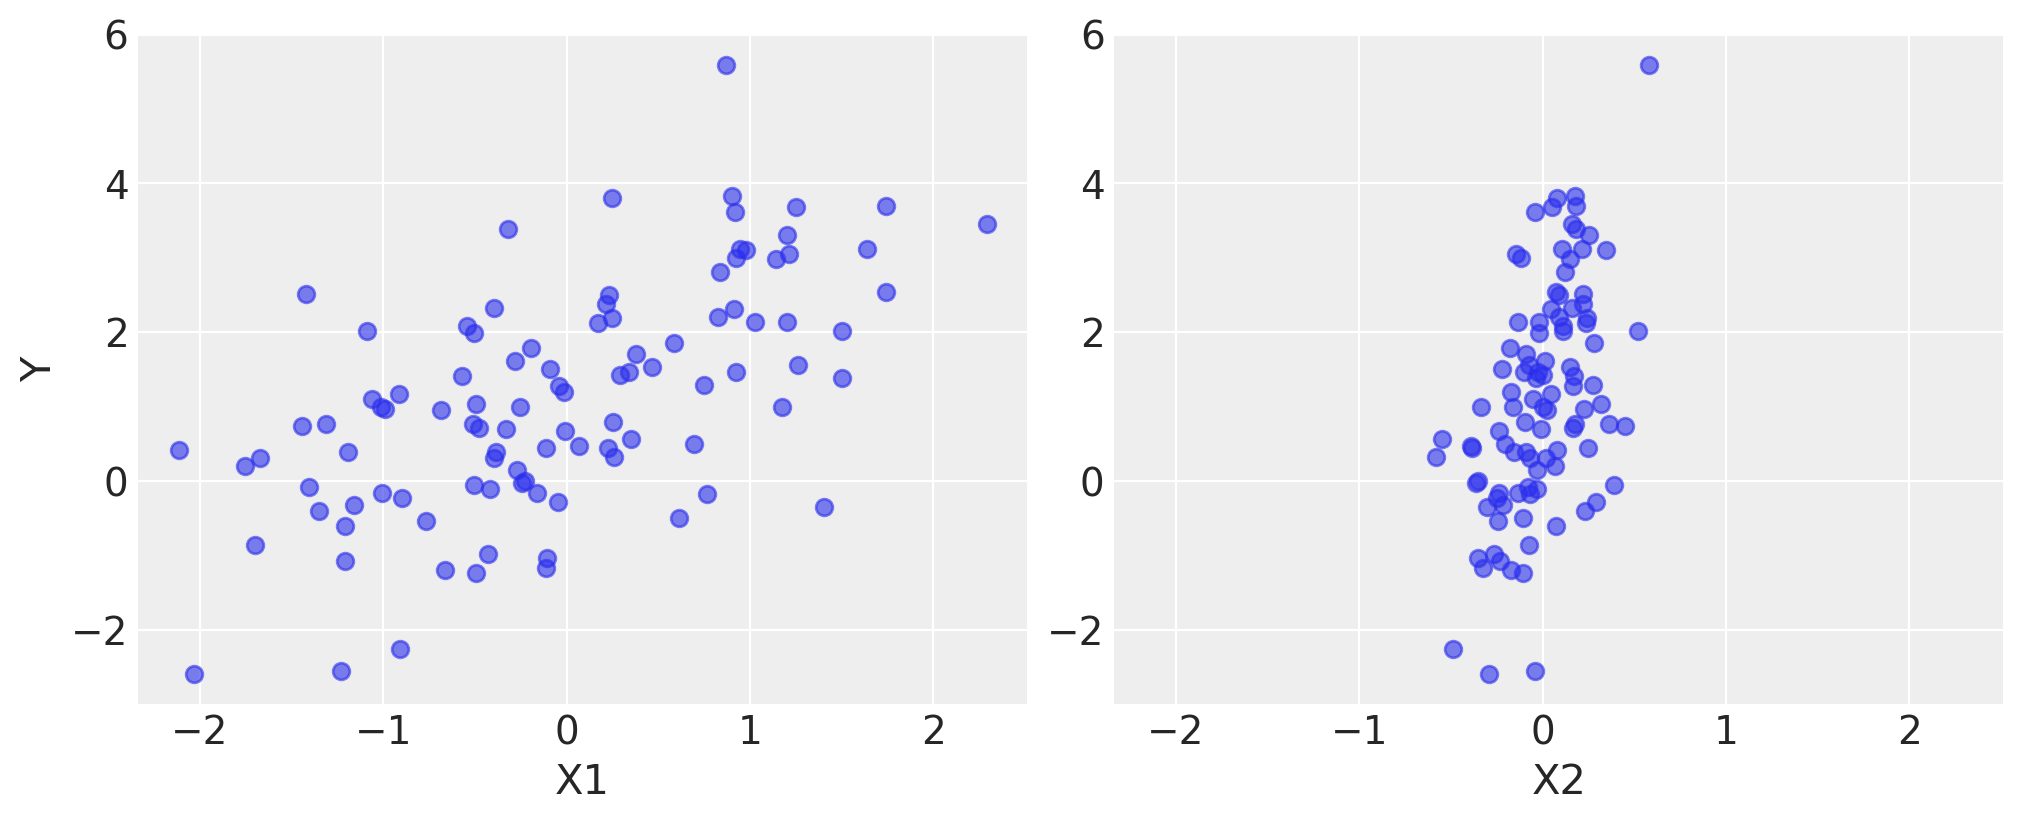

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2")

#### Model Specification
PyMCの構文は統計記法と似ているので、PyMCでこのモデルを指定するのは簡単です。ほとんどの場合、Pythonコードの各行は上記のモデル表記法の1行に対応します。


まず、PyMCをインポートします。ここでは```pm```としてインポートします。

In [5]:
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.12.0


では、モデルを構築してみよう。最初にモデルをすべて紹介し、次に各部分を一行ずつ説明する。

In [6]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu = 0, sigma = 10)
    beta = pm.Normal("beta", mu = 0, sigma = 10, shape = 2)# 2次元の説明変数の係数
    sigma = pm.HalfNormal("sigma", sigma = 1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

最初の行
```py
basic_model = pm.Model()
```
は、モデル確率変数のコンテナである新しいモデルオブジェクトを生成します。


モデルのインスタンス化に続いて、モデルのコンポーネントの指定は```with```文の中で行われます：
```py
with_basic_model：
```
これは、```basic_model```をコンテキストとして、インデントされたブロックが終了するまでのすべてのステートメントを含むコンテキストマネージャを作成します。これは、```with```文の下のインデントされたコードブロックで導入されたすべてのPyMCオブジェクトが裏でモデルに追加されることを意味します。このコンテキストマネージャーイディオムがなければ、変数を作成した直後に、それぞれの変数を手動で```basic_model```に関連付けることを余儀なくされるでしょう。もし```with model:```ステートメントなしで新しいランダム変数を作成しようとすると、その変数が追加されるべき明らかなモデルがないのでエラーになります。


コンテキスト・マネージャの最初の3つのステートメント
```py
alpha = pm.Normal('alpha', mu = 0, sigma = 10)
beta = pm.Normal('beta', mu = 0, sigma = 10, shape = 2)
sigma = pm.HalfNormal('sigma', sigma = 1)
```
平均0、標準偏差10の回帰係数の正規分布事前分布と、オブザベーションの標準偏差$\sigma$の半正規分布を持つ確率的確率変数を作成します。これらの値が確率的なのは、その一部が確率変数の従属グラフの親によって決定されるからである。


```pm.Normal```コンストラクタを呼び出して、正規事前分布として使用する確率変数を作成します。最初の引数は常に確率変数の名前で、これは出力を要約するためにモデルから変数を取り出すために使われることがあるので、代入されるPython変数の名前とほぼ一致する必要があります。確率オブジェクトに必要な残りの引数はパラメータで、この場合は ```mu``` が平均、```sigma``` が標準偏差で、モデルのハイパーパラメータ値を代入します。一般に、分布のパラメータは、分布のパラメータ化によって、確率変数の位置、形状、またはスケールを決定する値です。```Beta```, ```Exponential```, ```Categorical```, ```Gamma```, ```Binomial```など、一般的に使用される分布のほとんどがPyMCで利用可能です。


```beta```変数には、サイズ2のベクトル値パラメータを表す```shape```引数が追加されています。```shape```引数はすべての分布で利用可能で、確率変数の長さや形状を指定しますが、スカラー変数の場合はデフォルト値が1であるため省略可能です。配列を指定するには整数を、多次元配列を指定するにはタプルを指定します（例えば、```shape=(5,7)``` は5×7の行列値をとる確率変数を作ります）。


分布、サンプリング方法、その他のPyMC関数に関する詳細な注記は、APIドキュメントを参照してください。


事前分布を定義した次の文は、線形関係を指定して結果の期待値```mu```を作成します：
```py
mu = alpha + beta[0]*X1 + beta[1]*X2
```
これは決定論的確率変数を作成し、その値が親の値によって完全に決定されることを意味します。つまり、親の値に内在する以上の不確実性はありません。ここで、```mu``` は、切片 ```alpha``` と ```beta``` の係数と予測変数の2つの積の合計だけであり、それらの値が何であろうと、です。


PyMCの確率変数とデータは、新しい確率変数を作成するために、任意に加算、減算、分割、乗算、インデックスインすることができます。これによって，モデルの表現力を高めることができます．```sum```，```sin```，```exp```のような一般的な数学関数や， ```dot```（内積）や ```inv```（逆行列）のような線形代数関数も提供されています．


モデルの最後の行は、データセット中の結果のサンプリング分布である```Y_obs```を定義している。
```py
Y_obs = Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
```
これは確率変数の特殊なケースで、我々は**観測確率変数**と呼び、モデルのデータ尤度を表します。データを変数に渡す引数```observed```は、この変数の値が観測されたものであることを示し、モデルに適用されるフィッティング・アルゴリズムによって変更されるべきでないことを除けば、標準的なストキャスティクスと同じです。データは```ndarray```または```DataFrame```オブジェクトの形式で渡すことができます。


モデルの事前分布とは異なり、```Y_obs```の正規分布のパラメータは固定値ではなく、決定論的対象```mu```と確率論的```sigma```であることに注意。これにより、尤度とこれら2つの変数の間に親子関係が生まれます。

In [7]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


```sample```関数は、割り当てられた（または渡された）ステップメソッドを与えられた反復回数実行し、収集されたサンプルを含む```InferenceData```オブジェクトを、サンプリング実行の統計や観測データのコピーのような他の有用な属性とともに返します。```sample```は、マシン上の計算コアの数に応じて、並列チェーンのセットを生成したことに注意してください。

In [8]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

```InferenceData```オブジェクトの様々な属性は、変数名から```numpy.array```へのマップを含む```dict```と同様の方法で問い合わせることができます。例えば、```idata.posterior```属性へのインデックスとして変数名を使用することで、```alpha```潜在変数からのサンプリングトレースを取得することができます。返される配列の最初の次元は連鎖インデックスで、2番目の次元はサンプリングインデックスです。各チェーンでの```alpha```変数の最初の5つの値を、以下のように見ることができます：

In [9]:
idata.posterior["alpha"].sel(draw = slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)> Size: 160B
array([[1.09005791, 1.20641107, 1.03423947, 1.26580358, 1.0784767 ],
       [1.18120866, 1.15312411, 1.28789065, 1.09983093, 1.22515608],
       [1.11345236, 1.15758201, 1.10155682, 1.25741032, 0.97811336],
       [1.12966037, 1.21921803, 1.13711832, 1.17630439, 1.20579937]])
Coordinates:
  * chain    (chain) int32 16B 0 1 2 3
  * draw     (draw) int32 20B 0 1 2 3 4

もしNUTS（自動的に割り当てられる）の代わりにスライスサンプリングアルゴリズムを使ってパラメーターをサンプリングしたいのであれば、```sample```の```step```引数にこれを指定すればよかった。

In [10]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    slice_idata = pm.sample(5000, step = step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [beta]
>Slice: [sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 35 seconds.


#### Posterior analysis
PyMCのプロットや診断の機能は、Arvizというプラットフォームに依存しない専用のパッケージによって処理されるようになりました。 ```plot_trace```を使って簡単な事後プロットを作成することができます。

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

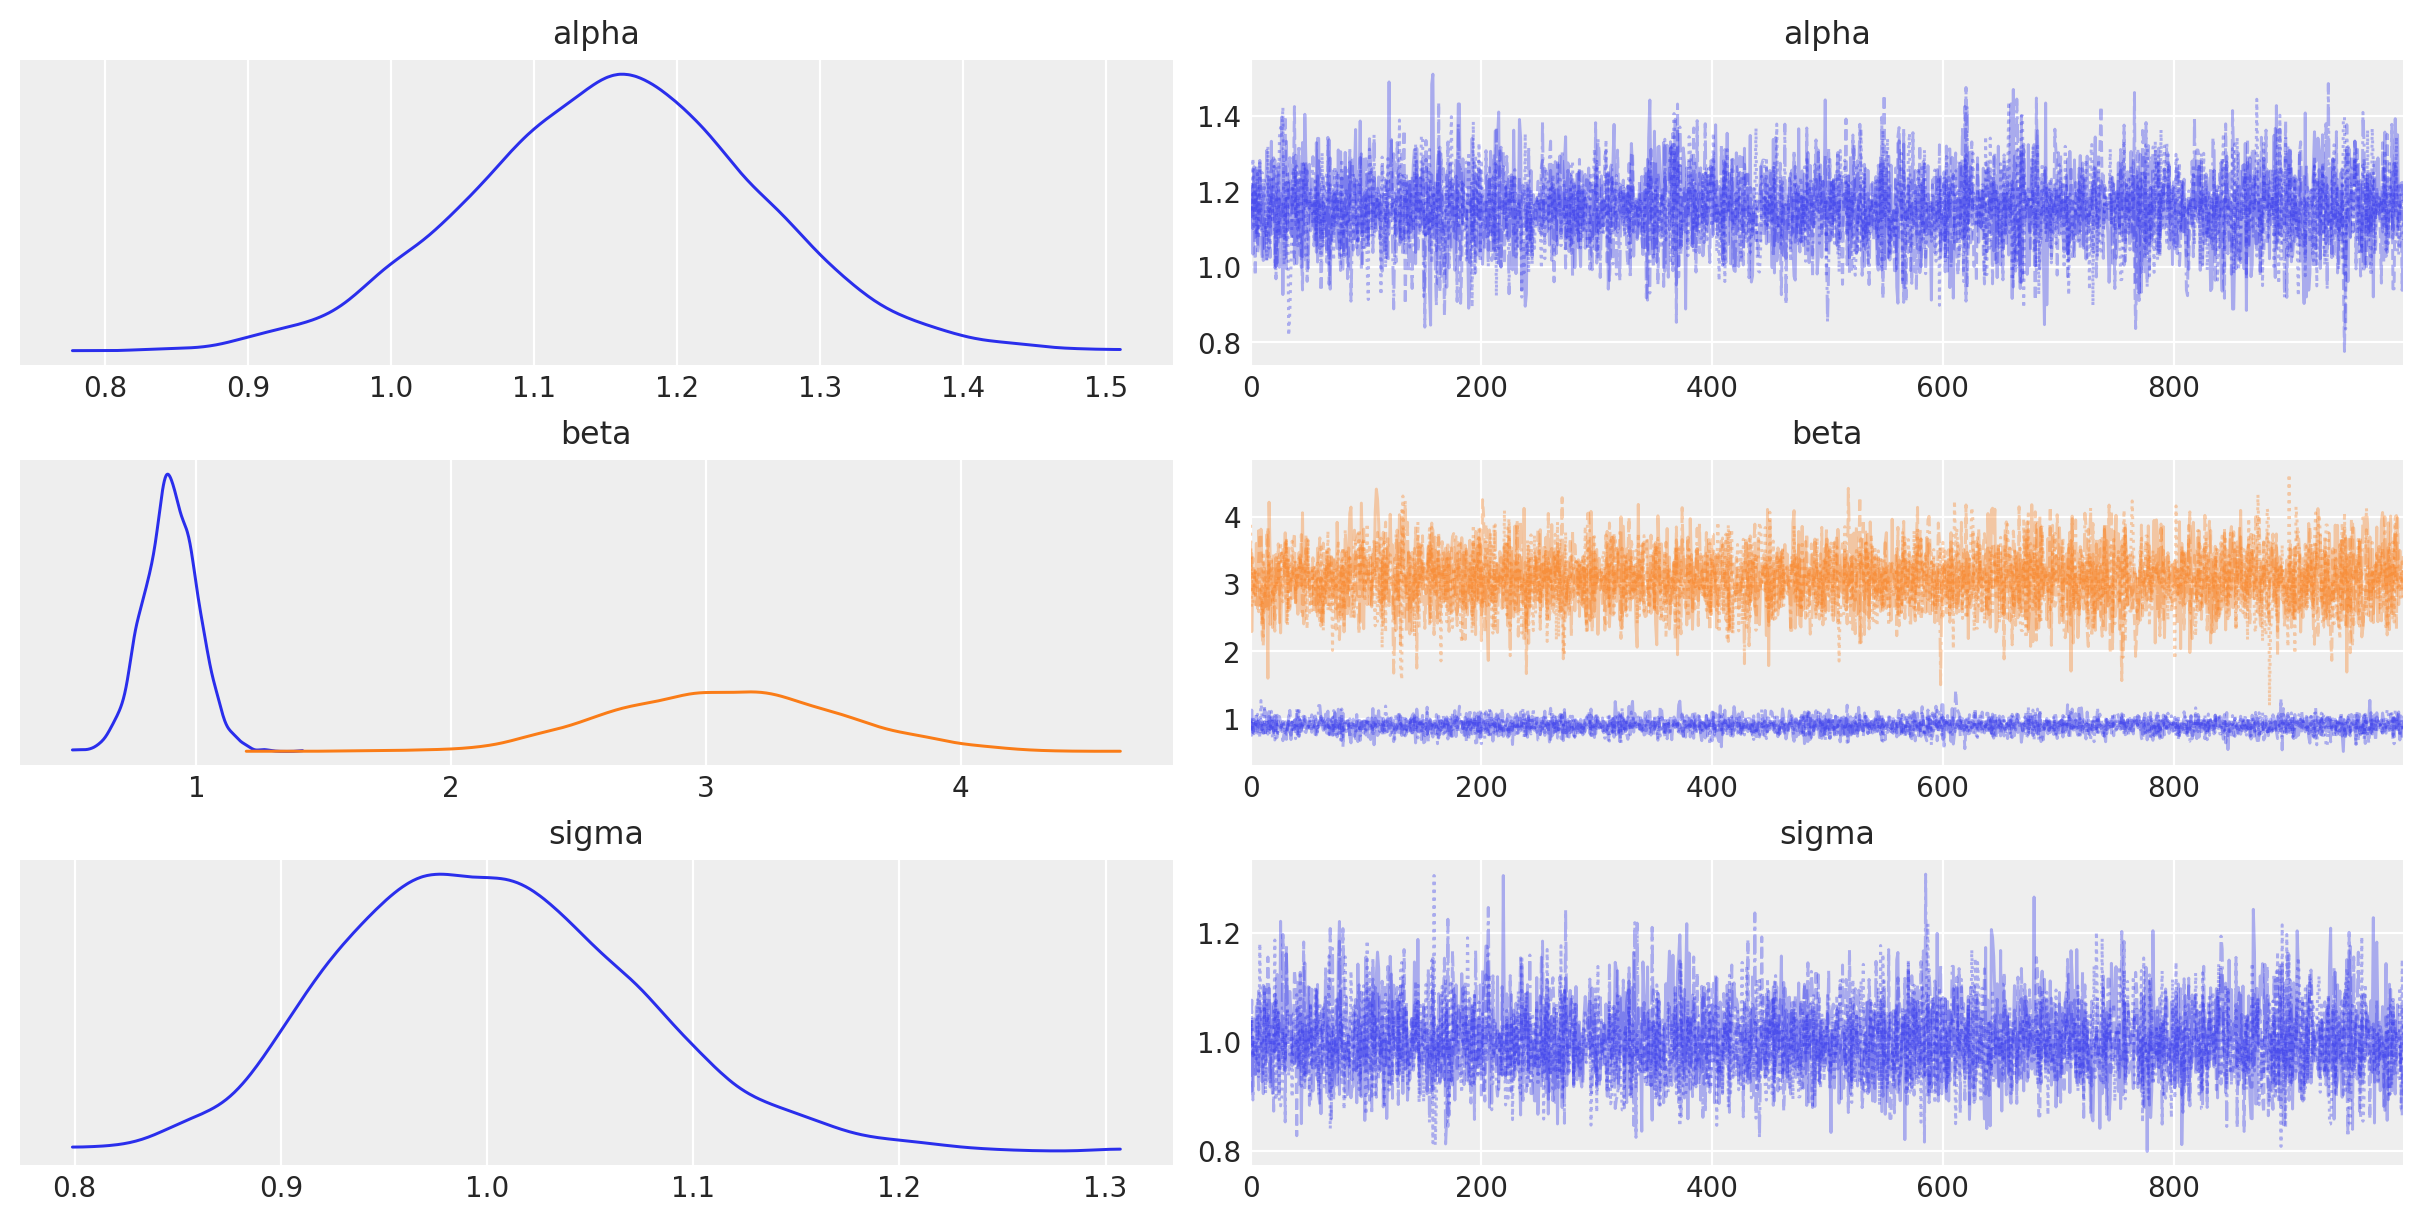

In [11]:
az.plot_trace(idata, combined=True)

左の列は、各確率確率変数の周辺事後値の平滑化ヒストグラム（カーネル密度推定を使用）で構成され、右の列は、マルコフ連鎖のサンプルが逐次順序でプロットされている。```beta```変数は、ベクトル値であるため、2つの密度プロットと2つのトレース・プロットを生成し、これは両方の予測係数に対応します。

さらに、```summary```関数は、一般的な事後統計量のテキストベースの出力を提供します：

In [12]:
az.summary(idata, round_to = 2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    1.16  0.10    0.96     1.35       0.00      0.0   5795.69   3123.32   
beta[0]  0.90  0.10    0.71     1.10       0.00      0.0   4909.94   2926.24   
beta[1]  3.07  0.44    2.31     3.92       0.01      0.0   6009.72   2905.48   
sigma    1.00  0.07    0.88     1.15       0.00      0.0   5756.54   3235.22   

         r_hat  
alpha      1.0  
beta[0]    1.0  
beta[1]    1.0  
sigma      1.0

### Case study 1: Educational Outcomes for Hearing-impaired Children
動機づけとなる例として、聴覚障害を持つ子供の教育成果のデータセットを使用する。ここでは、学習成果の良し悪しに関連する要因を決定することに関心がある。

#### The Data
この匿名化されたデータセットはListening and Spoken Language Data Repository (LSL-DR)から引用されたもので、難聴を持ち、聞き取りと話し言葉の発達を支援することに焦点を当てたプログラムに登録されている子供たちの人口統計学的および縦断的な結果を追跡する国際的なデータリポジトリである。研究者たちは、これらのプログラムにおける教育成果の改善に関連する要因を発見することに興味を持っている。


利用可能な予測因子には以下のようなものがある：
* 性別（```male```）
* 世帯内の兄弟姉妹の数（```siblings```）
* 家族の関与の指標（```family_inv```）
* 世帯の主要言語が英語でないか（```non_english```）
* 過去の障害の有無（```prev_disab```）
* 白人以外の人種（```non_white```）
* 検査時の年齢（月単位、```age_test```）
* 難聴が重度でないか（```non_severe_hl```）
* 対象者の母親が高校卒業以上の学歴を取得しているかどうか（```mother_hs```）
* 聴覚障害が生後3ヶ月までに発見されたかどうか（```early_ident```）

結果変数は、いくつかの学習領域のうちの1つにおける標準化テストのスコアである。

In [13]:
# ローカル環境でデータを読み込めるようにコード変更
test_scores = pd.read_csv("../../data/test_scores.csv", index_col=0)
test_scores.head()

score  male  siblings  family_inv  non_english  prev_disab  age_test  \
0     40     0       2.0         2.0        False         NaN        55   
1     31     1       0.0         NaN        False         0.0        53   
2     83     1       1.0         1.0         True         0.0        52   
3     75     0       3.0         NaN        False         0.0        55   
5     62     0       0.0         4.0        False         1.0        50   

   non_severe_hl  mother_hs  early_ident  non_white  
0            1.0        NaN        False      False  
1            0.0        0.0        False      False  
2            1.0        NaN        False       True  
3            0.0        1.0        False      False  
5            0.0        NaN        False      False

<Axes: >

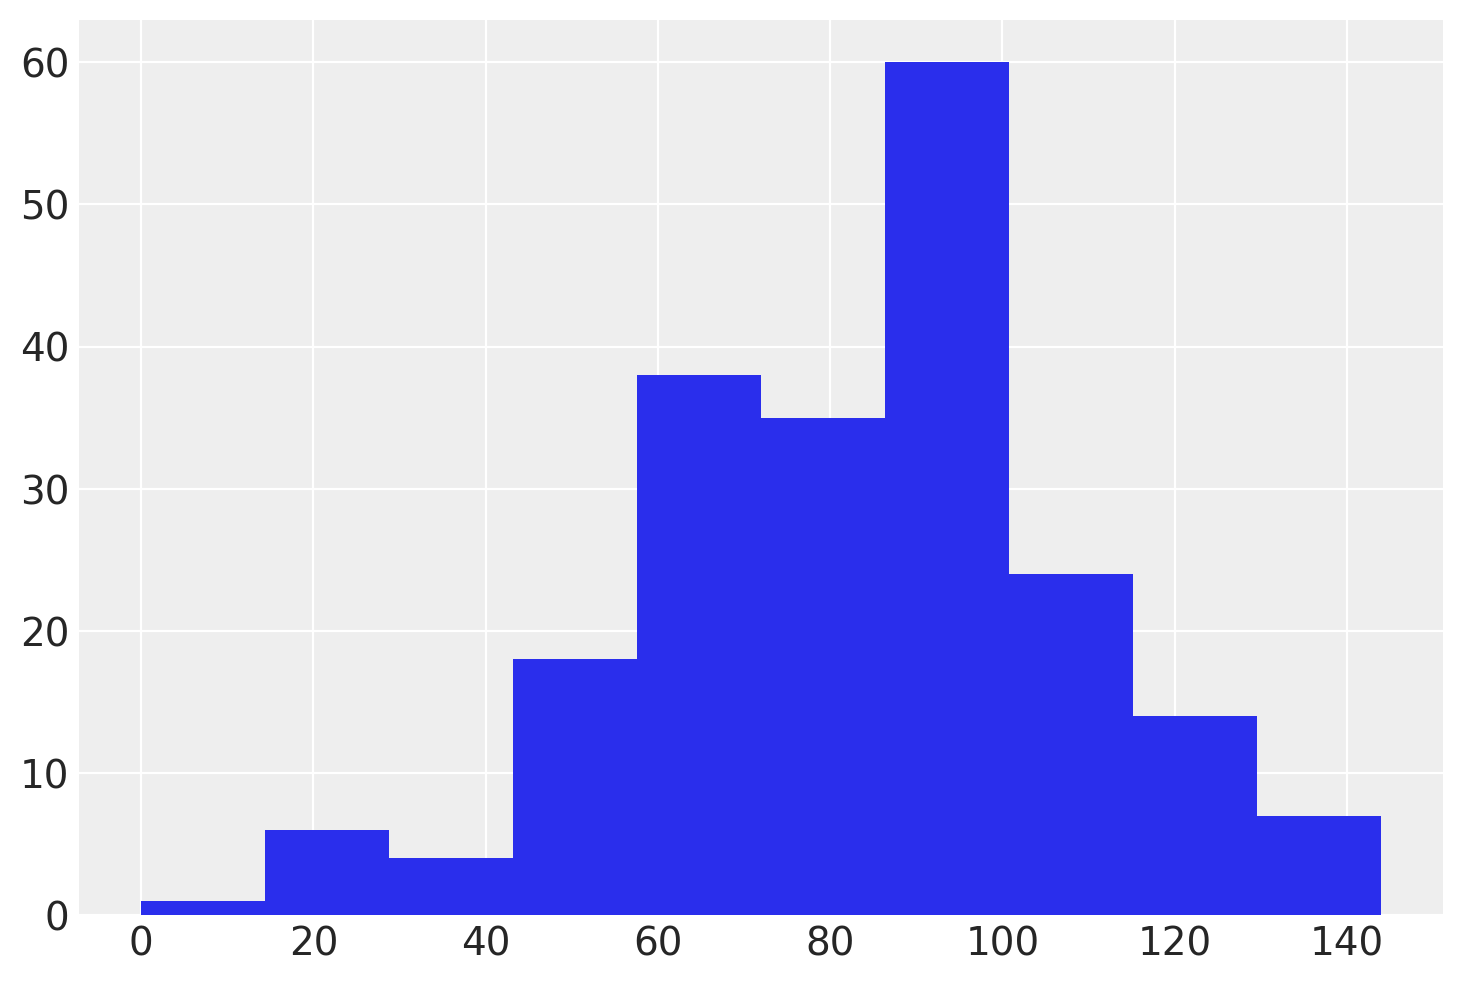

In [14]:
test_scores["score"].hist()

In [15]:
# Dropping missing values is a very bad idea in general, but we do so here for simplicity
X = test_scores.dropna().astype(float)
y = X.pop("score")

# Standardize the features
X -= X.mean()
X /= X.std()

N, D = X.shape

#### The Model
これは最初の回帰の例よりも現実的な問題で、**多変量回帰**モデルを扱っているからです。しかし、LSL-DRデータセットにはいくつかの潜在的な予測変数があるが、どれが効果的な統計モデルを構築するのに関連するかを事前に決定するのは難しい。変数選択を行うためのアプローチはいくつかありますが、よく使われる自動化された方法は正則化で、それによって、効果のない共変量が結果の予測に寄与しない場合、正則化（ペナルティの一種）によってゼロに向かって縮小されます。


正則化については、機械学習や古典的な統計学のアプリケーションで聞いたことがあるかもしれません。そこでは、ラッソーやリッジ回帰のような手法が、回帰パラメータのサイズにペナルティを適用することによって、パラメータをゼロに向かって縮小します。ベイズの文脈では，回帰係数に適切な事前分布を適用する．そのような事前分布の1つが階層的正則化馬蹄で、これは2つの正則化戦略（1つは大域的正則化、もう1つは局所的正則化）を使用します。これをうまく機能させる鍵は、収縮事前分布としてロングテール分布を選択することである。


各回帰係数$\beta _i$のホレシュー事前分布は次のようになる：

$$
\beta _i \sim N(0, \tau ^2 \cdot \tilde{\lambda}^2)
$$

ここで、$\sigma$ は誤差標準偏差の事前分布で、モデルの尤度にも使われる。
ここで、$\tau$は大域的収縮パラメータ、$\tilde{\lambda _i}$は局所的収縮パラメータである。
まずグローバルから：
$\tau$の事前分布には、Half-StudentT 分布を使用する。

$$
\tau \sim Half-StudentT_2 \biggl( \frac{D_0}{D - D_0} \cdot \frac{\sigma}{ \sqrt{N} } \biggr)
$$

この事前分布のパラメタリゼーションは、ゼロでない係数の真の数を表す値$D_0$を事前に指定する必要がある。幸運なことに、この値の妥当な推測があればよく、真の数の1桁以内であればよい。予測変数の数の半分を推測値として使おう．

In [16]:
D0 = int(D / 2)

一方、局所的な収縮パラメータは比率によって定義される：

$$
\tilde{\lambda} ^2 _i = \frac{ c^2 \lambda ^2 _i }{ c^2 + \tau ^2 \lambda ^2 _i }
$$

大域的な収縮と同様に、$lambda _i$にはロングテールの$Half-StudentT_5(1)$を用いる。
c^2$は厳密には正である必要があるが、長尾である必要はないので、$c^2$の逆ガンマ事前分布$c^2 \sim InverseGamma(1, 1)$が合う。


最後に、NUTSサンプラーがより効率的に$beta _i$をサンプリングできるように、以下のようにパラメータを変更する：

$$
Z_i \sim N(0, 1)\\
\beta _i = z_i \cdot \tau \cdot \tilde{\lambda}_i
$$

この再パラメーター化は、実際によく遭遇する。

#### Model Specification
PyMCでモデルを指定すると、統計的な仕様が反映されます。このモデルでは、$tau$と$lambda$のプライアに```HalfStudentT```分布、$c^2$変数にInverseGamma分布を採用しています。


PyMCでは、```InverseGamma``` のような純粋に正の事前分布を持つ変数は対数変換されます。これにより、サンプリングがよりロバストになります。裏では、制約のない空間の変数（```<変数名>_log``` という名前）がサンプリングのためにモデルに追加されます。```Beta``` や ```Uniform``` のように2辺を制約する事前分布を持つ変数も、制約のない変数に変換されますが、対数オッズ変換が行われます。


また、入力変数名を "predictors "と呼ばれる座標としてモデルに渡すことで、PyMCとArviZの名前付き次元を利用します。これにより、この名前のベクトルをベクトル値パラメータの ```shape```整数引数の代わりとして渡すことができます。そして、モデルは適切な名前を、推定する各潜在パラメータに関連付けます。これはセットアップに少し手間がかかりますが、後でモデルの出力を扱うときに大きな利益をもたらすでしょう。


このモデルをPyMCでエンコードしてみよう：

In [17]:
import pytensor.tensor as at

with pm.Model(coords={"predictors": X.columns.values}) as test_score_model:
    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 25)

    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 5, dims = "predictors")
    c2 = pm.InverseGamma("c2", 1, 1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors")
    # Shrunken coefficients
    beta = pm.Deterministic(
        "beta", z * tau * lam * at.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )
    # No shrinkage on intercept
    beta0 = pm.Normal("beta0", 100, 25.0)

    scores = pm.Normal("scores", beta0 + at.dot(X.values, beta), sigma, observed = y.values)

我々は ``beta`` の計算を ``Deterministic`` PyMC クラスでラップしていることに注意してください。詳しくは後述するが、これによって決定論的変数の値がサンプルのトレースに保持されるようになる。


また、``Model`` という名前を最初の例のように2行に分けるのではなく、コンテキストマネージャーの最初の行で ``test_score_model`` と宣言していることにも注意してください。


モデルが完成したら、モデルのグラフをプロットするGraphVizを使って、その構造を見ることができます。コーディングミスを犯しやすいので、コーディングしたモデルの関係が正しいことを確認するのに便利です。

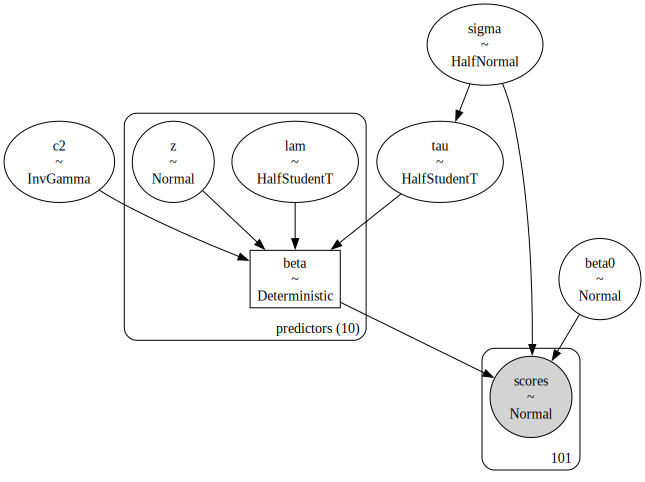

In [18]:
pm.model_to_graphviz(test_score_model)

先に進む前に、モデルがデータを見る前に何をするか見てみましょう。モデルからシミュレーション・データを生成するために、事前予測サンプリングを行うことができます。そして、これらのシミュレーションをデータセットの実際のテストの得点と比較してみましょう。

In [19]:
with test_score_model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [beta0, c2, lam, scores, sigma, tau, z]


In [20]:
Sampling: [beta0, c2, lam, scores, sigma, tau, z]

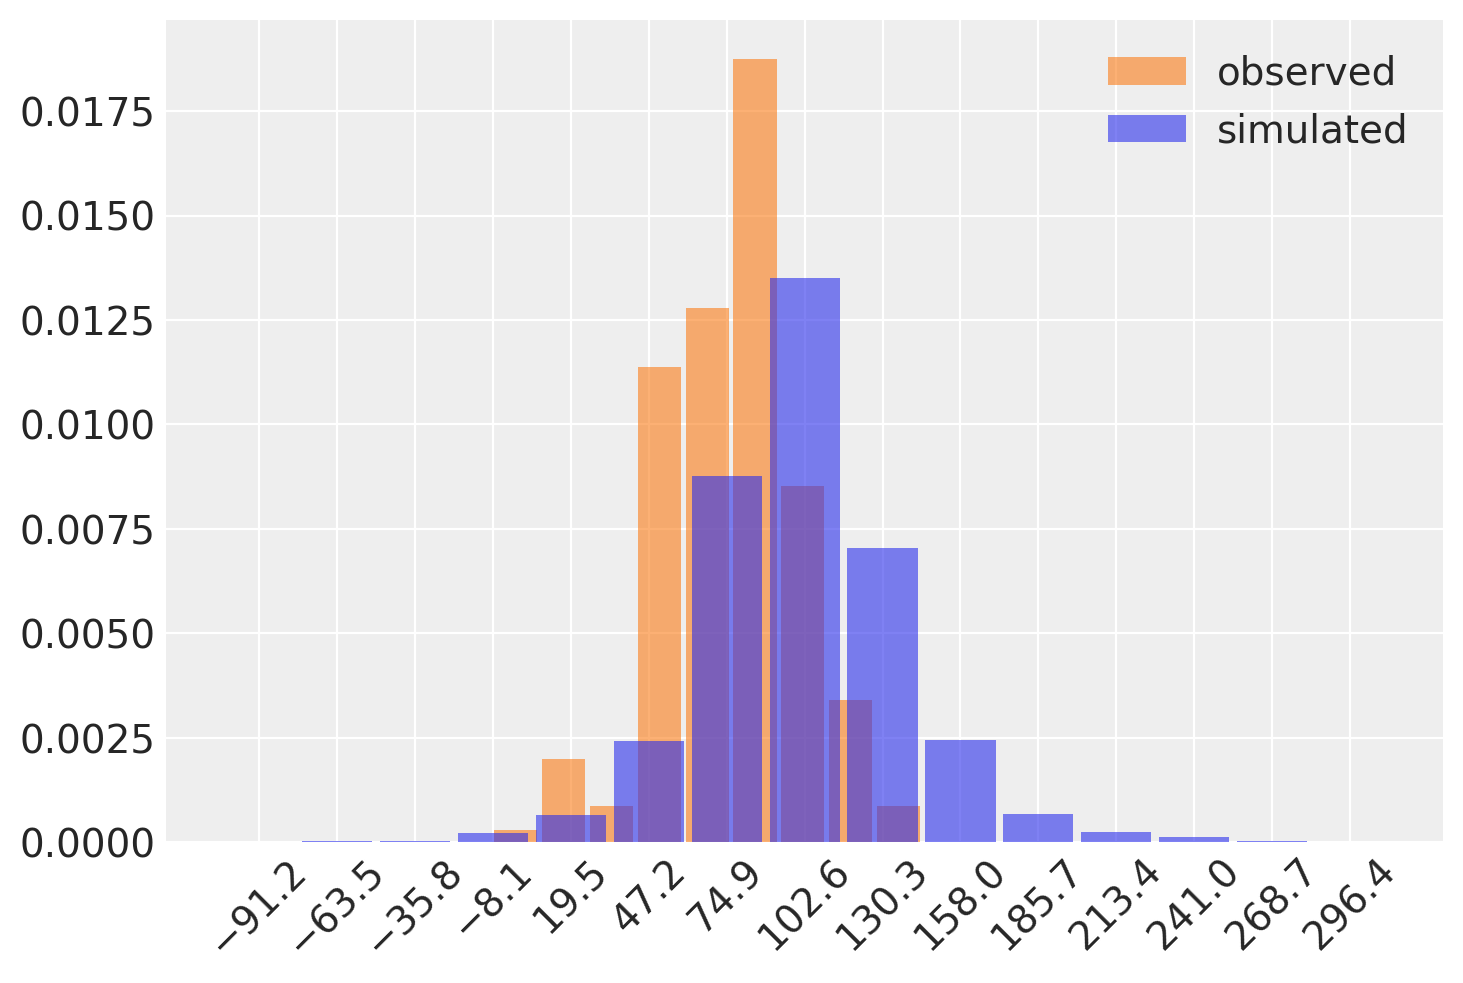

In [21]:
az.plot_dist(
    test_scores["score"].values,
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    prior_samples.prior_predictive["scores"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)
plt.xticks(rotation=45);

これが妥当かどうか、どうすればわかるのか？これには、問題の領域に関する知識が必要である。ここでは、テストの得点の結果を予測しようとしています。もし我々のモデルが、もっともらしい得点を除外しながら、数千の値や多くの負の値を予測していたとしたら、我々はモデルの仕様を間違えていることになります。シミュレーション・データの分布のサポートが、観測された得点分布のサポートと完全に重なっていることがわかります！いくつかの負の値や、もっともらしいというには大きすぎる値がありますが、心配することはありません。

#### Model Fitting
さて、簡単な部分です： PyMCの "推論ボタン "は``sample``の呼び出しです。このモデルはデフォルト値（1000反復）より少し長くチューニングさせる。これにより、NUTSサンプラーが十分にチューニングできるようになります。

In [22]:
with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 37 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


乖離に関するいくつかの警告があることに注意。これらは、NUTSが事後分布を横切って有効な移動を行うことができなかったサンプルであり、その結果得られた点はおそらく事後分布からの代表的なサンプルではない。この例ではそれほど多くないので心配する必要はありませんが、アドバイスに従って ``target_accept`` をデフォルト値の0.9から0.99に増やしてみましょう。

In [23]:
with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 62 seconds.


目標合格率が大きいので、アルゴリズムはリープフロッグステップをより控えめにし、小さくしている。その代償として、各サンプルが完了するのに時間がかかります。しかし、警告はなくなり、きれいな事後サンプルが得られます！

#### Model Checking
モデルチェックの簡単な最初のステップは、明らかな問題をチェックするために、単変量潜在パラメータのトレースプロットを見ることによって、サンプルを視覚的に検査することです。これらの名前は ``plot_trace`` の ``var_names`` 引数に渡すことができる。

In [24]:
az.plot_trace(idata, var_names=["tau", "sigma", "c2"])

array([[<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'c2'}>, <Axes: title={'center': 'c2'}>]],
      dtype=object)

これで大丈夫でしょうか？左側の各パラメータの密度は、他のものとよく似ています。これは、同じ事後分布に収束していることを意味します（正しい分布かどうかは別として）。右側のトレースプロットの均質性も良い兆候です。サンプリングされた値の時系列に傾向やパターンはありません。 ``c2`` と ``tau`` は時折極端な値をサンプリングすることがあるが、これは重いしっぽの分布から予想されることである。


次の簡単なモデル・チェックのステップは、NUTSサンプラーが期待通りに動作したかどうかを確認することである。エネルギー・プロットは、NUTSアルゴリズムが事後分布を適切に探索できたかどうかをチェックする方法である。もしそうでなければ、事後分布の一部が適切な頻度で探索されず、偏った事後推定になる危険性があります。このプロットは2つの密度推定値を示している。1つはサンプリング実行の限界エネルギー分布で、もう1つはステップ間のエネルギー遷移の分布である。これは少し抽象的ですが、私たちが求めているのは、分布が互いに似ていることです。我々の分布はそれほど悪くはないようだ。

In [25]:
az.plot_energy(idata)

<Axes: >

最終的には、予測係数のセットである ``beta`` の推定値に興味があります。``plot_trace`` に ``beta`` を渡すと、非常に混雑したプロットが生成されるので、代わりにベクトル値のパラメータを扱うように設計されている ``plot_forest`` を使用する。

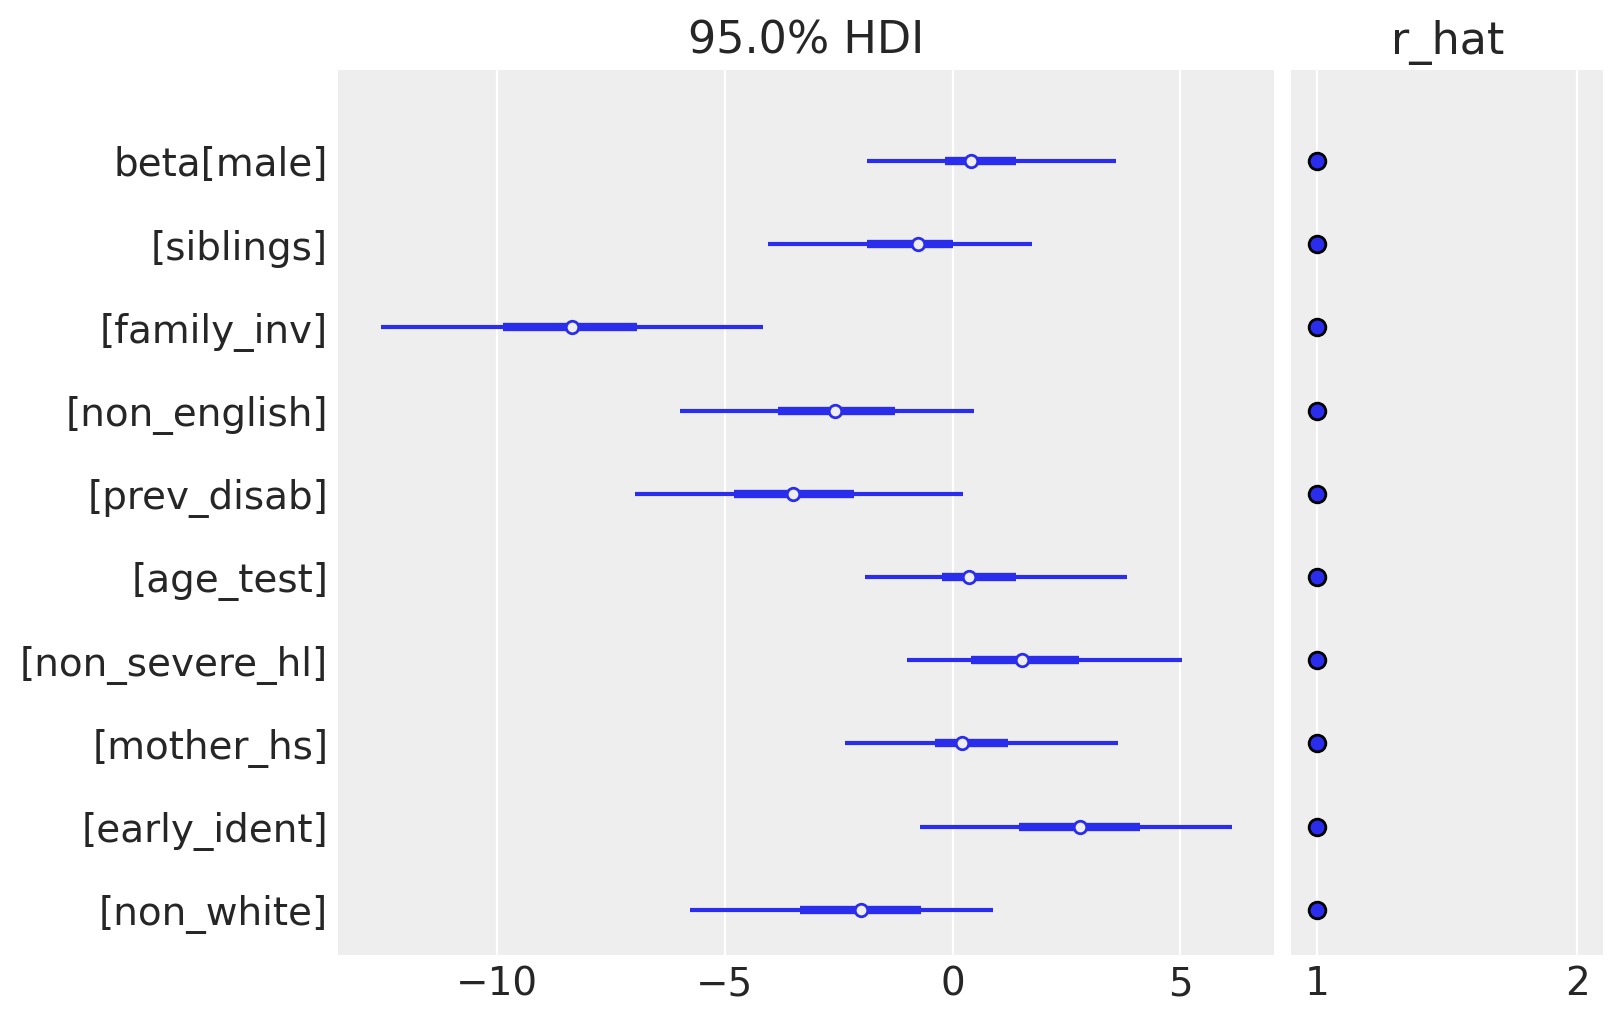

In [26]:
az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

係数の事後分布から、テスト得点の予測に重要であると思われるいくつかの要因が明らかになった。家族の関与（``family_inv``）は大きく、負の値である。これは、スコアが大きいほど（これはより悪い関与に関連する）、テストのスコアがずっと悪くなることを意味する。一方、聴覚障害の早期発見は正であり、これは早期に問題を発見することが、その後の教育成果をより良くすることを意味し、これも直感的である。他の変数、特に性別（``male``）、テスト時の年齢（``age_test``）、母親の教育状態（``mother_hs``）は、すべて基本的にゼロに縮小されていることに注意されたい。

## Case study 2: Coal mining disasters
1851年から1962年までに英国で記録された石炭採掘災害の時系列を考えてみよう（Jarrett, 1979）。災害件数はこの間の安全規制の変更の影響を受けていると考えられる。残念なことに、パンダの ``Series`` で ``nan`` が欠損していることが確認された欠損データのある年の組もあります。これらの欠損値はPyMCによって自動的にインプットされます。


次に、この系列のモデルを構築し、変化がいつ起こったかを推定しようとします。同時に、欠損データの取り扱い方、多重サンプラーの使用、離散確率変数からの標本の取り方を見ます。

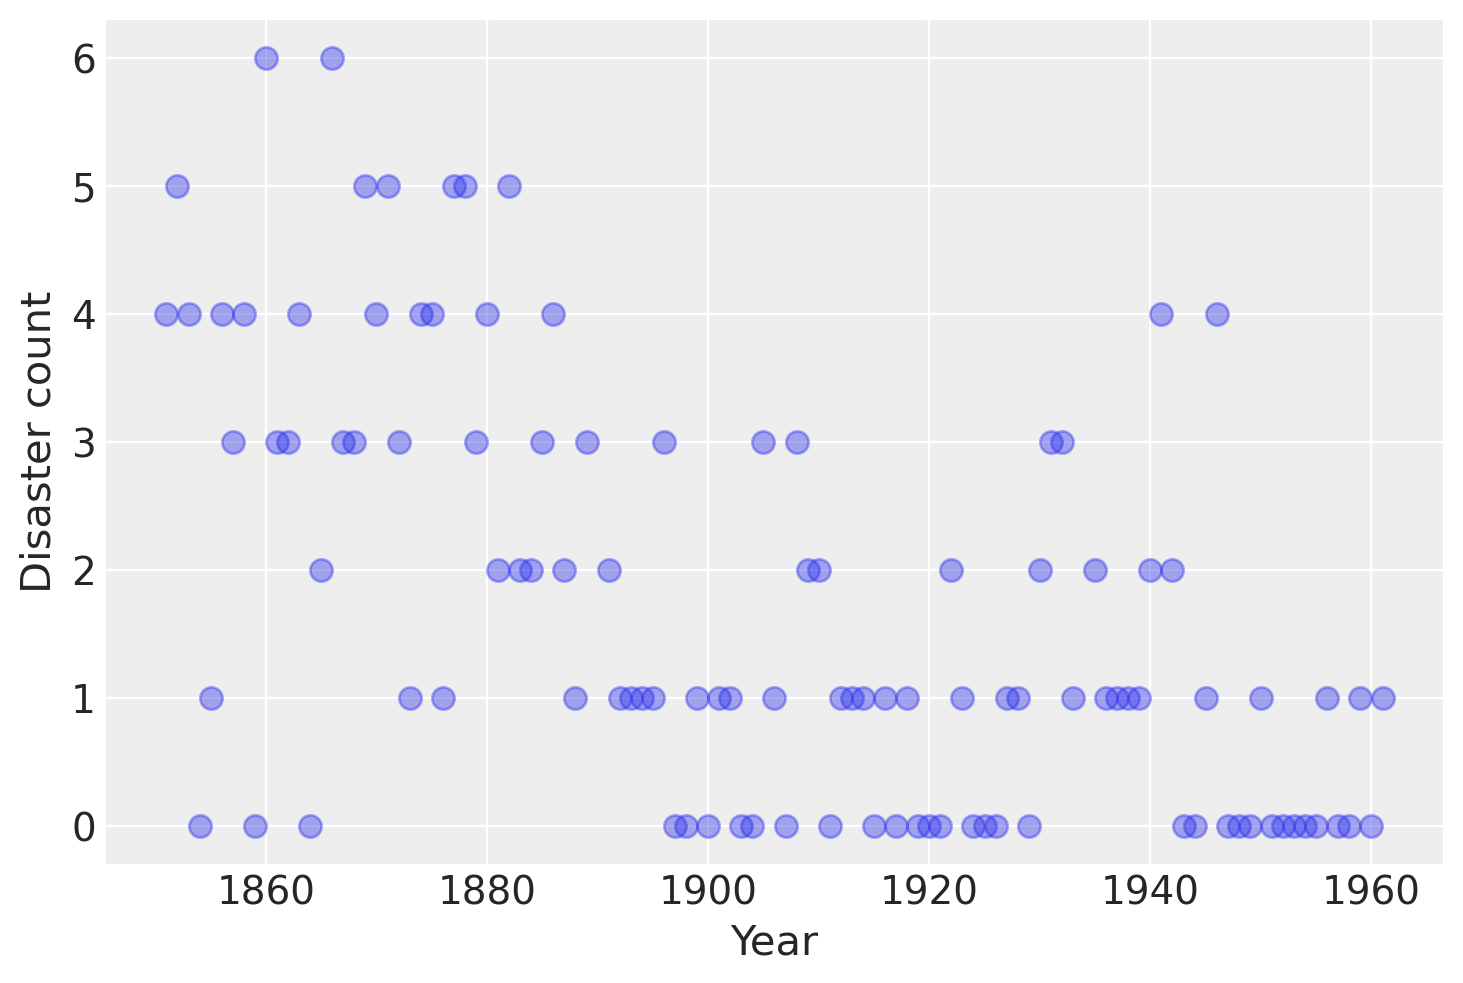

In [27]:
# fmt: off
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)
# fmt: on
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year");

この時系列における災害の発生は、時系列の初期には大きな割合パラメータを持つポアソン過程に従い、後期には小さな割合パラメータを持つポアソン過程に従うと考えられる。我々は、おそらく鉱山安全規制の変更に関連する時系列の変化点を見つけることに関心がある。


我々のモデルでは、

$$
\begin{align}
D_t & \sim Pois(r_t), \
r_t = \begin{cases}
e, \  if \ t  \leq s\\
l, \ if \ t  \gt s
\end{cases}\\

s & \sim Unif(t_l, t_h)\\

e & \sim exp(1)\\

l & \sim(1)

\end{align}
$$

パラメータは以下のように定義されている：
* $D_t$： t$ 年における災害回数
* r_t$： r_t$: 年$t$における災害のポアソン分布の割合パラメータ。.
* $s$: s$：割合パラメータが変化する年（スイッチポイント）。
* $e$: e$: 切り替え点 $s$ より前の割合パラメータ。
* $l$: l$: 切り替え点 $s$ より後のレート・パラメーター。
* t_l$, $t_h$ : 年$t$の下限と上限。


このモデルは我々のこれまでのモデルとほぼ同様に構築されている。主な違いは、ポアソン事前分布と離散一様事前分布を持つ離散変数の導入と、決定論的確率変数``rate``の新しい形式である。

In [28]:
with pm.Model() as disaster_model:
    switchpoint = pm.DiscreteUniform("switchpoint", lower=years.min(), upper=years.max())

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\pymc\model\core.py:1303: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\pymc\model\core.py:1317: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


確率変数のロジック、
```py
rate = switch(switchpoint >= year, early_rate, late_rate)
```
は ``switch`` というif文のように動作する関数を使って実装されている。この関数は最初の引数を使って次の2つの引数を切り替えます。


欠損値は、観測確率変数を作成する際に、NumPy の ``MaskedArray`` または ``DataFrame`` に NaN 値を渡すことで透過的に処理されます。裏側では、欠損値をモデル化するために ``disasters.missing_values`` という別の確率変数が作成されます。


残念ながら、それらは離散変数であり、したがって意味のある勾配を持たないので、 ``スイッチポイント`` や欠損災害オブザベーションのサンプリングにNUTSを使用することはできない。その代わりに、離散値を扱うように設計されているので、適応的メトロポリス・ヘイスティングスを実装した ``メトロポリス`` ステップ法を用いてサンプリングします。PyMCは自動的に正しいサンプリングアルゴリズムを割り当てます。

In [29]:
with disaster_model:
    idata = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint]
>>Metropolis: [disasters_unobserved]
>NUTS: [early_rate, late_rate]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 53 seconds.


下のトレースプロットでは、安全性が大きく変化する可能性のあるスパンが約10年あり、確率の塊の大部分を含むスパンが5年あることがわかる。分布がギザギザしているのは、年の切り替え点と尤度の間の関係が不規則であるためで、ギザギザはサンプリングエラーによるものではありません。

In [30]:
axes_arr = az.plot_trace(idata)
plt.draw()
for ax in axes_arr.flatten():
    if ax.get_title() == "switchpoint":
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels(labels, rotation=45, ha="right")
        break
plt.draw()

確率変数``rate``はトレースに現れないことに注意してほしい。それ自体に興味があるわけではないので、この場合はそれでよい。前の例を思い出してほしい。この変数を ``Deterministic`` クラスでラップし、名前をつけてトレースする。


以下のプロットは、オレンジ色の垂直線と、半透明の帯で示した最高事後密度（HPD）でスイッチポイントを示している。黒の破線は事故率を示す。

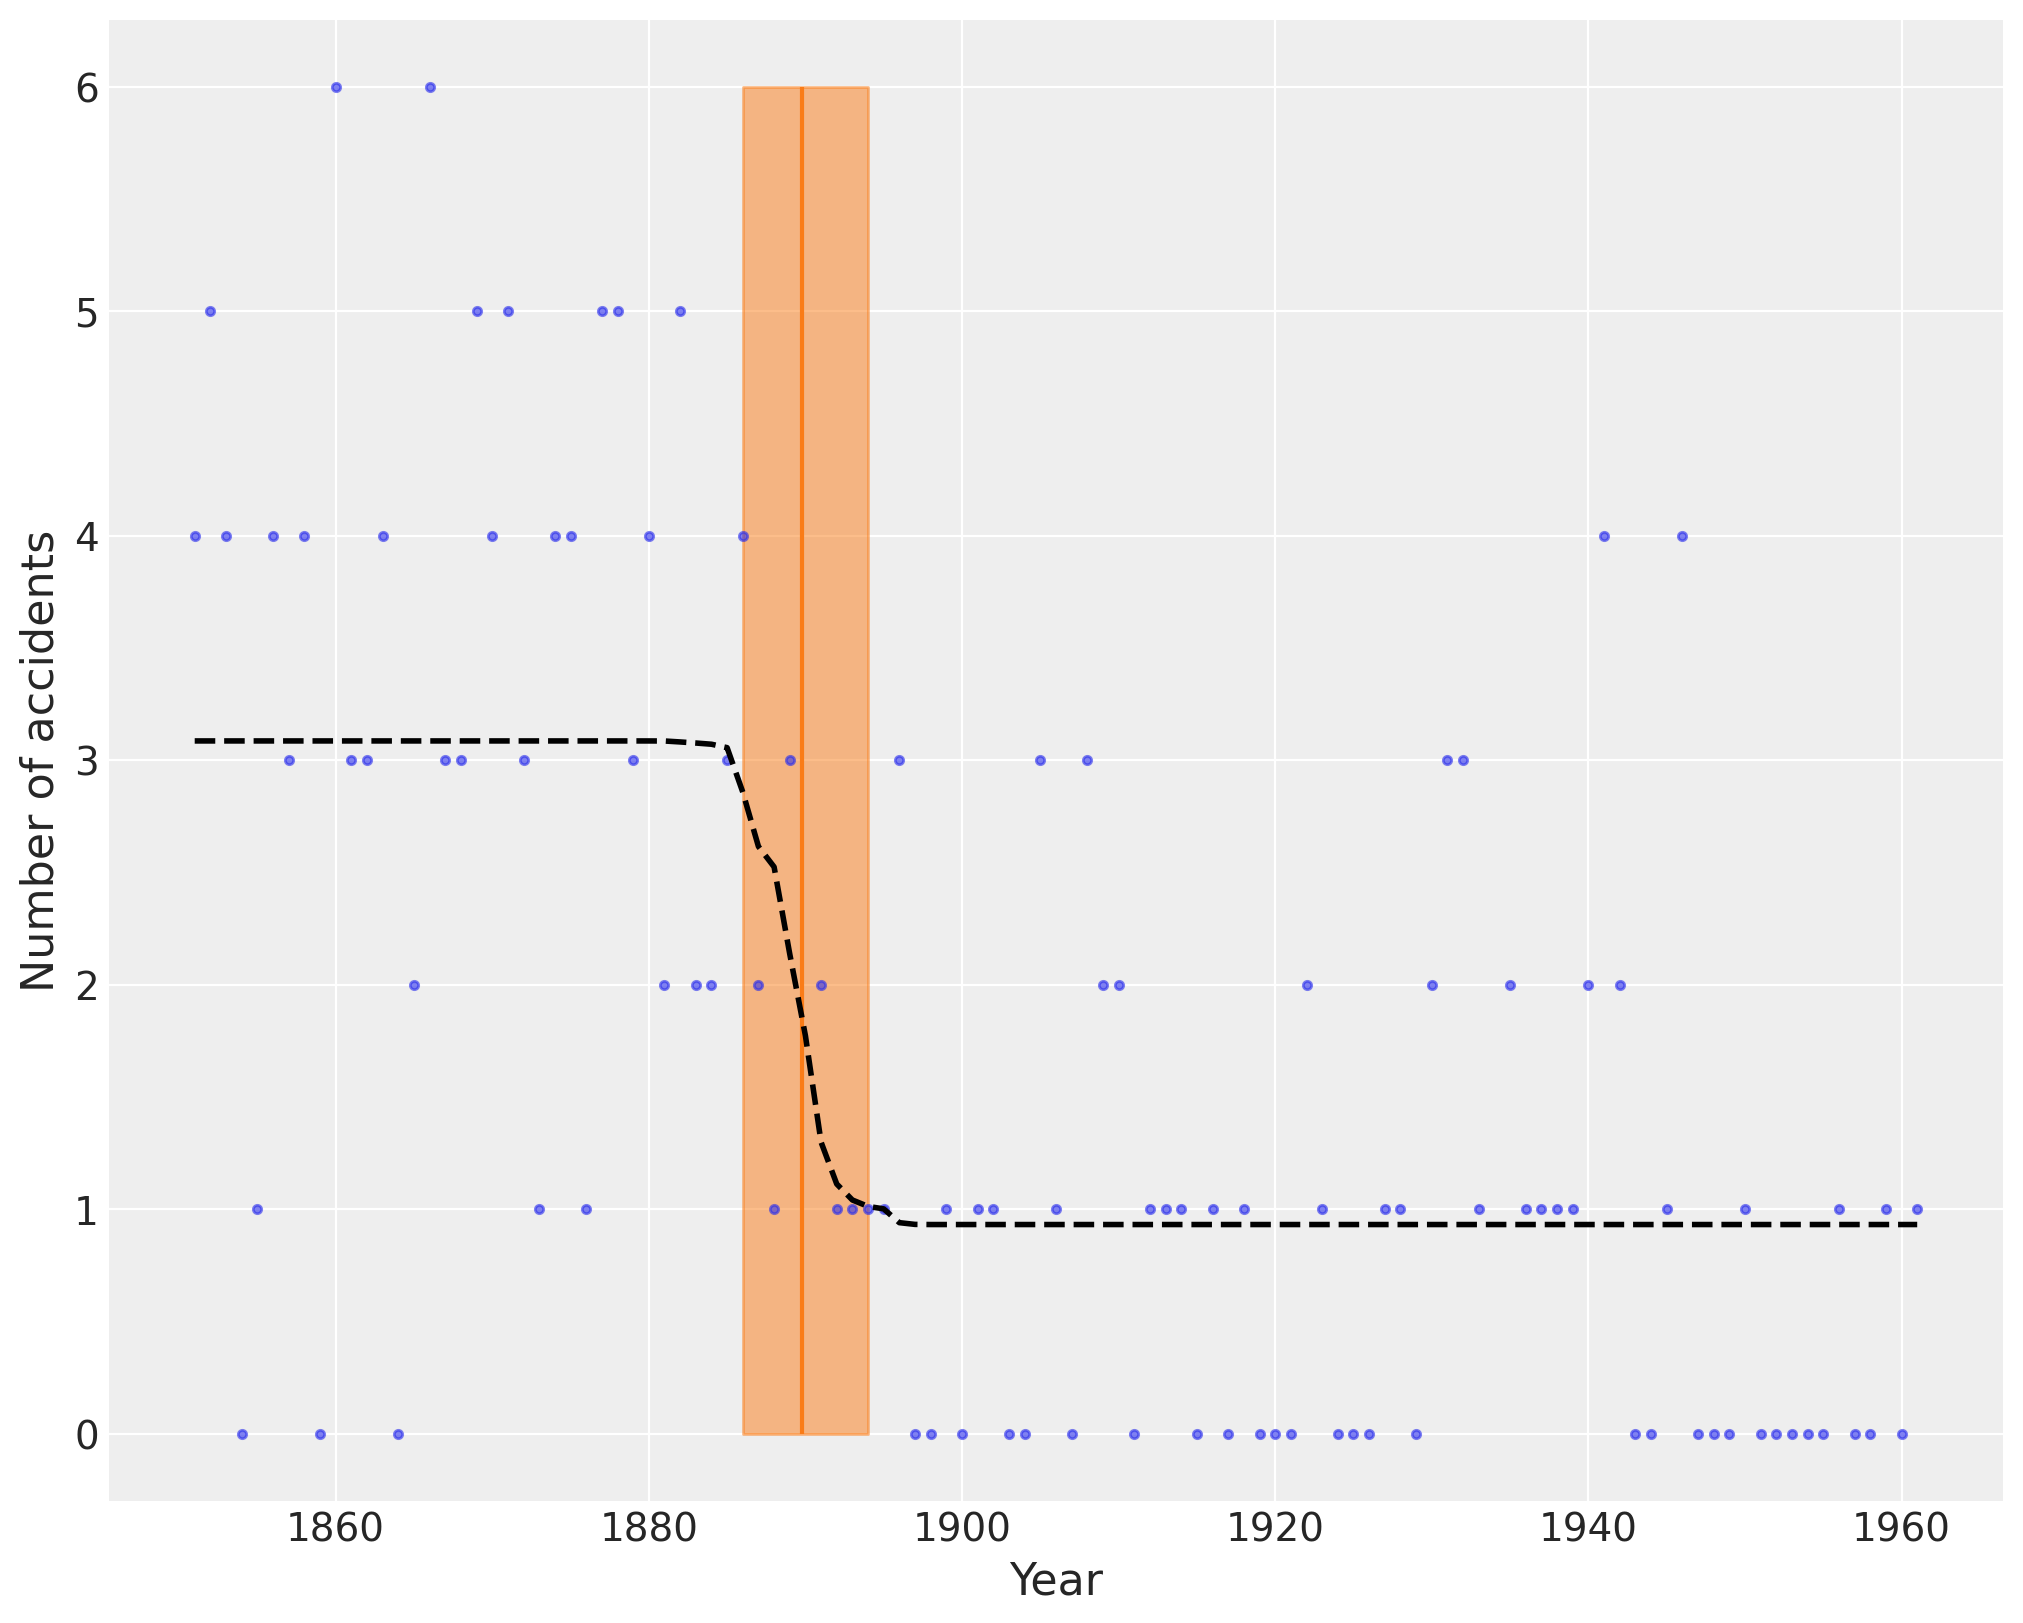

In [31]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, ".", alpha=0.6)
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

trace = idata.posterior.stack(draws=("chain", "draw"))

plt.vlines(trace["switchpoint"].mean(), disaster_data.min(), disaster_data.max(), color="C1")
average_disasters = np.zeros_like(disaster_data, dtype="float")
for i, year in enumerate(years):
    idx = year < trace["switchpoint"]
    average_disasters[i] = np.mean(np.where(idx, trace["early_rate"], trace["late_rate"]))

sp_hpd = az.hdi(idata, var_names=["switchpoint"])["switchpoint"].values
plt.fill_betweenx(
    y=[disaster_data.min(), disaster_data.max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)
plt.plot(years, average_disasters, "k--", lw=2);

### Arbitrary deterministics
PyTensorに依存しているため、PyMCは確率変数を新しい確率変数に変換するための多くの数学関数と演算子を提供します。しかし、PyTensorの関数ライブラリは完全ではないため、PyTensorとPyMCは、純粋なPythonで任意の関数を作成し、これらの関数をPyMCモデルに含める機能を提供します。これは ``as_op`` 関数デコレータでサポートされています。


PyTensorは関数の入力と出力の型を知る必要があり、入力は ``itypes``、出力は ``otypes`` で ``as_op`` を指定する。

In [32]:
from pytensor.compile.ops import as_op


@as_op(itypes=[at.lscalar], otypes=[at.lscalar])
def crazy_modulo3(value):
    if value > 0:
        return value % 3
    else:
        return (-value + 1) % 3


with pm.Model() as model_deterministic:
    a = pm.Poisson("a", 1)
    b = crazy_modulo3(a)

このアプローチの重要な欠点は、ハミルトニアンベースのサンプラーに必要な勾配を計算するために、``pytensor``がこれらの関数を検査することができないことである。したがって、このような演算子を使用するモデルにHMCやNUTSサンプラーを使用することはできない。しかし、 ``as_op`` を使用する代わりに ``Op`` を継承すれば、勾配を追加することができます。PyMCのサンプルセットには、as_opを使用したより精巧な例が含まれている。

### Arbitrary distributions
同様に、PyMCの統計分布のライブラリは完全ではありませんが、PyMCでは任意の確率分布に対してユーザ定義の関数を作成することができます。単純な統計分布の場合、 ``DensityDist`` クラスは対数確率 $log \bigl( p(x) \bigr)$ を計算する任意の関数を引数にとります。この関数は計算に他の確率変数を使用することができる。以下は、Jake Vanderplasによる線形回帰にどの事前分布を使用するかに関するブログ投稿（Vanderplas, 2014）にインスパイアされた例です。

In [33]:
# エラーが出たので,コメントアウトする
'''
import pytensor.tensor as at

with pm.Model() as model:
    alpha = pm.Uniform('intercept', -100, 100)
    
    # Create custom densities
    beta = pm.DensityDist('beta', logp=lambda value: -1.5 * at.log(1 + value**2))
    eps = pm.DensityDist('eps', logp=lambda value: -at.log(at.abs_(value)))
    
    # Create likelihood
    like = pm.Normal('y_est', mu=alpha + beta * X, sigma=eps, observed=Y)
'''

"\nimport pytensor.tensor as at\n\nwith pm.Model() as model:\n    alpha = pm.Uniform('intercept', -100, 100)\n    \n    # Create custom densities\n    beta = pm.DensityDist('beta', logp=lambda value: -1.5 * at.log(1 + value**2))\n    eps = pm.DensityDist('eps', logp=lambda value: -at.log(at.abs_(value)))\n    \n    # Create likelihood\n    like = pm.Normal('y_est', mu=alpha + beta * X, sigma=eps, observed=Y)\n"

より複雑な分布については、 ``Continuous`` または ``Discrete`` のサブクラスを作成し、必要に応じてカスタムの ``logp`` 関数を提供することができます。これがPyMCの組み込み分布の指定方法です。例として、心理学や天体物理学のような分野では、数値近似を必要とするような複雑な尤度関数があります。


上記の ``beta`` 変数を ``Continuous`` サブクラスとして実装したものを以下に示します。また、関連する ``RandomVariable`` オブジェクトも示します。

In [34]:
class BetaRV(at.random.op.RandomVariable):
    name = "beta"
    ndim_supp = 0
    ndims_params = []
    dtype = "floatX"

    @classmethod
    def rng_fn(cls, rng, size):
        raise NotImplementedError("Cannot sample from beta variable")


beta = BetaRV()

In [35]:
class Beta(pm.Continuous):
    rv_op = beta

    @classmethod
    def dist(cls, mu=0, **kwargs):
        mu = at.as_tensor_variable(mu)
        return super().dist([mu], **kwargs)

    def logp(self, value):
        mu = self.mu
        return beta_logp(value - mu)


def beta_logp(value):
    return -1.5 * at.log(1 + (value) ** 2)


with pm.Model() as model:
    beta = Beta("beta", mu=0)

logpをPyTensorで表現できない場合は、次のように``as_op``で関数を装飾することができます： ``as_op(types=[at.dscalar], otypes=[at.dscalar])``。この場合、Pythonのブラックボックス関数が作成され、処理速度が大幅に低下し、NUTSなどに必要な勾配が得られないことに注意してください。

### Discussion
確率プログラミングは統計学習における新たなパラダイムであり、ベイズモデリングはその重要なサブ分野である。確率的プログラミングの特徴である、変数を確率分布として指定すること、変数を他の変数やオブザベーションに条件付けることは、様々な設定において、またモデルの複雑さの範囲において、モデルを構築するための強力なツールとなる。確率プログラミングの台頭とともに、ベイズモデルのフィッティング手法の革新が急速に進み、既存のMCMC手法と比較して顕著な改善が見られます。しかし、このような拡大にもかかわらず、方法論の革新に追いついたソフトウェアパッケージはほとんどなく、専門家でなくてもモデルを実装できるソフトウェアパッケージはさらに少ない。


PyMC は、定量的研究者が統計モデルを柔軟かつ簡潔に実装するための確率的プログラミング プラットフォームを提供します。 統計分布の大規模なライブラリといくつかの事前定義されたフィッティング アルゴリズムにより、ユーザーはベイジアン モデリングの実装の詳細ではなく、当面の科学的問題に集中できます。 ドメイン固有の言語ではなく Python を開発言語として選択することは、PyMC ユーザーが動的で高レベルのプログラミング言語を使用して、対話的にモデルの構築、モデル オブジェクトのイントロスペクト、作業のデバッグやプロファイリングを行うことができることを意味します。 それは学ぶのが簡単です。 PyMC のモジュール式のオブジェクト指向設計は、新しいフィッティング アルゴリズムやその他の機能の追加が簡単であることを意味します。 さらに、PyMC には、他のほとんどのパッケージには見られないいくつかの機能が付属しており、最も注目すべきはハミルトニアン ベースのサンプラーと、Stan のみが提供する制約付き確率変数の自動変換です。 ただし、Stan とは異なり、PyMC は離散変数だけでなく、Metropolis-Hastings や Slice サンプリングなどの非勾配ベースのサンプリング アルゴリズムもサポートしています。


PyMC の開発は継続的に行われており、将来のバージョンではいくつかの機能が計画されています。 最も注目すべき点は、変分推論手法は一般化可能性を犠牲にして、MCMC サンプリングよりも効率的であることがよくあります。 しかし、より最近では、自動微分変分推論 (ADVI; Kucukelbir et al., 2017) などのブラックボックス変分推論アルゴリズムが開発されました。 このアルゴリズムは PyMC に追加される予定です。 オープンソースの科学計算ツールキットとして、ベイジアン モデルの新しいフィッティング アルゴリズムを開発する研究者が PyMC でリファレンス実装を提供することを推奨します。 サンプラーは純粋な Python コードで記述できるため、一般的に実装して任意の PyMC モデルで動作させることができ、作成者がメソッドを使用するためのより多くの聴衆を得ることができます。

### References
* Bastien, F., Lamblin, P., Pascanu, R., Bergstra, J., Goodfellow, I., Bergeron, A., Bouchard, N., Warde-Farley, D., and Bengio, Y. (2012) “Theano: new features and speed improvements”. NIPS 2012 deep learning workshop.

* Bergstra, J., Breuleux, O., Bastien, F., Lamblin, P., Pascanu, R., Desjardins, G., Turian, J., Warde-Farley, D., and Bengio, Y. (2010) “Theano: A CPU and GPU Math Expression Compiler”. Proceedings of the Python for Scientific Computing Conference (SciPy) 2010. June 30 - July 3, Austin, TX

* Duane, S., Kennedy, A. D., Pendleton, B. J., and Roweth, D. (1987) “Hybrid Monte Carlo”, Physics Letters, vol. 195, pp. 216-222.

* Hoffman, M. D., & Gelman, A. (2014). The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo. The Journal of Machine Learning Research, 30.

* Jarrett, R.G. A note on the intervals between coal mining disasters. Biometrika, 66:191–193, 1979.

* Kucukelbir A, Dustin Tran, Ranganath R, Gelman A, and Blei DM. Automatic differentiation variational inference, The Journal of Machine Learning Research. 18 , pp. 430-474.

* Lunn, D.J., Thomas, A., Best, N., and Spiegelhalter, D. (2000) WinBUGS – a Bayesian modelling framework: concepts, structure, and extensibility. Statistics and Computing, 10:325–337.

* Neal, R.M. Slice sampling. Annals of Statistics. (2003). doi:10.2307/3448413. Patil, A., D. Huard and C.J. Fonnesbeck. (2010) PyMC: Bayesian Stochastic Modelling in Python. Journal of Statistical Software, 35(4), pp. 1-81

* Piironen, J., & Vehtari, A. (2017). Sparsity information and regularization in the horseshoe and other shrinkage priors. Electronic Journal of Statistics, 11(2), 5018-5051.

* Stan Development Team. (2014). Stan: A C++ Library for Probability and Sampling, Version 2.5.0.

* Vanderplas, Jake. “Frequentism and Bayesianism IV: How to be a Bayesian in Python.” Pythonic Perambulations. N.p., 14 Jun 2014. Web. 27 May. 2015.

In [36]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Mon Apr 01 2024

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

xarray: 2024.3.0

arviz     : 0.17.1
matplotlib: 3.8.3
pytensor  : 2.19.0
pymc      : 5.12.0
pandas    : 2.2.1
numpy     : 1.26.4

Watermark: 2.4.3

